In [51]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import json
from sklearn.model_selection import train_test_split
import random
import math
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import scipy
# import implicit

## EDA

In [2]:
df = pd.read_csv('100k_a.csv', header=None)
df = df.rename(columns={0: 'user_id', 1: 'stream_id', 2: 'streamer_name', 3: 'start_time', 4: 'stop_time'})
df

,user_id,stream_id,streamer_name,start_time,stop_time
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


In [3]:
df.isna().sum() # check for NAs

user_id          0
stream_id        0
streamer_name    0
start_time       0
stop_time        0
dtype: int64

In [ ]:
df['user_id'].nunique(), df['stream_id'].nunique(), df['streamer_name'].nunique() 

In [4]:
# Start and stop times are provided as integers and represent periods of 10 minutes.
df['start_time'] = df['start_time'] * 10
df['stop_time'] = df['stop_time'] * 10

In [5]:
# convert minutes to hours
df['time_spent'] = df['stop_time'] - df['start_time']

In [6]:
# check for outliers in time_spent; those who watch greater than 8 hours, unrealistic for someone to actively be watching a stream for longer than 8 hours and more likely just left tab open
df[df['time_spent'] > 480]

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
7071,247,34317269936,failverde,50820,51370,550
18587,649,34071314928,dota2ruhub,25530,26040,510
22627,769,34103327360,elmiillor,28400,28950,550
33314,1133,34104883024,tfue,28560,29280,720
33316,1133,34115354272,ninja,29810,30360,550
...,...,...,...,...,...,...
3035821,99543,34219020832,zironicdk,41130,41620,490
3042010,99699,34157423888,mejash,34730,35240,510
3044264,99776,34057571888,dota2ruhub,23790,24350,560
3044380,99776,34374601376,dota2ruhub,56820,57360,540


In [7]:
# only keep those who have watched <= 8 hours
df = df[df['time_spent'] <= 480]
df

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
0,1,33842865744,mithrain,1540,1560,20
1,1,33846768288,alptv,1660,1690,30
2,1,33886469056,mithrain,5870,5880,10
3,1,33887624992,wtcn,5890,5910,20
4,1,33890145056,jrokezftw,5910,5940,30
...,...,...,...,...,...,...
3051728,100000,34167930576,mckytv,35820,35830,10
3051729,100000,34168288656,natehill,35820,35830,10
3051730,100000,34169594512,fortnite,35820,35840,20
3051731,100000,34180223072,highdistortion,37090,37110,20


In [8]:
df['time_spent'].value_counts()

10     1559891
20      498252
30      263958
40      168944
50      115769
60       85323
70       64238
80       49751
90       40007
100      32180
110      26825
120      22509
130      18312
140      15173
150      12759
160      10884
170       9396
180       8149
190       6876
200       5834
210       4922
220       4384
230       3832
240       3292
250       2849
260       2276
270       1983
280       1740
290       1430
300       1308
310       1084
320        996
330        823
340        737
350        688
360        565
370        468
380        426
390        372
400        296
420        276
410        263
430        223
440        207
450        168
460        136
470        134
480         94
Name: time_spent, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3051002 entries, 0 to 3051732
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   stream_id      int64 
 2   streamer_name  object
 3   start_time     int64 
 4   stop_time      int64 
 5   time_spent     int64 
dtypes: int64(5), object(1)
memory usage: 162.9+ MB


In [10]:
df.describe()

,user_id,stream_id,start_time,stop_time,time_spent
count,3.051002e+06,3.051002e+06,3.051002e+06,3.051002e+06,3.051002e+06
mean,5.032247e+04,3.413001e+10,3.145919e+04,3.149048e+04,3.129228e+01
std,2.889483e+04,1.682299e+08,1.772582e+04,1.772713e+04,4.175118e+01
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+01,1.000000e+01
25%,2.528400e+04,3.398877e+10,1.617000e+04,1.620000e+04,1.000000e+01
50%,5.029800e+04,3.413068e+10,3.174000e+04,3.178000e+04,1.000000e+01
75%,7.545200e+04,3.427399e+10,4.676000e+04,4.679000e+04,3.000000e+01
max,1.000000e+05,3.441642e+10,6.147000e+04,6.148000e+04,4.800000e+02


In [11]:
# number of streamer_names and number of stream_ids are different, suggesting that each streamer_name maps to multiple stream_ids, use streamer_name as item
df['user_id'].nunique(), df['stream_id'].nunique(), df['streamer_name'].nunique() 

(100000, 739972, 162624)

In [ ]:
# drop irrelevant features:
df = df.drop(['streamer_id','start_time','stop_time'], axis=1)

C:\Users\sukhm\AppData\Local\Temp\ipykernel_8264\2070851834.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_streamers.index, y=top_streamers.values, palette='deep')


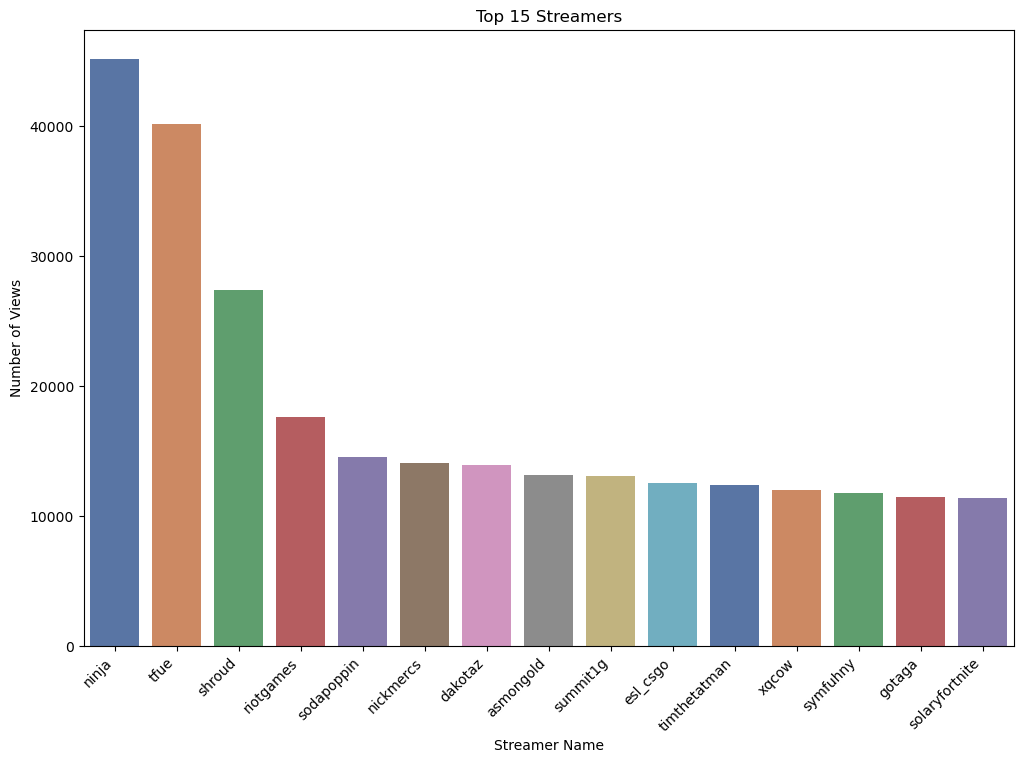

In [12]:
# Most popular streamers
top_streamers = df['streamer_name'].value_counts().nlargest(15)

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_streamers.index, y=top_streamers.values, palette='deep')
plt.title('Top 15 Streamers')
plt.xlabel('Streamer Name')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')
plt.show()


Text(0.5, 0, 'Number of Unique Streamers')

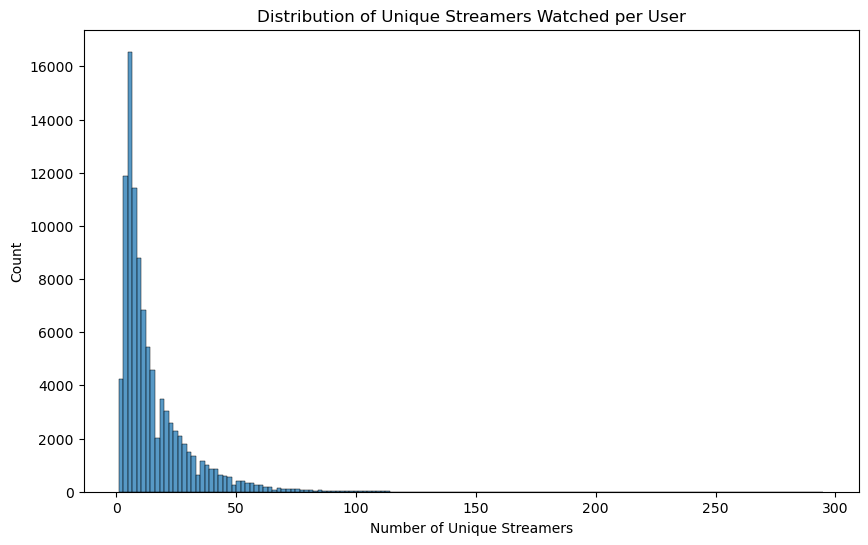

In [13]:
# Distribution of number of unique streamers watched by user
unique_streamers_per_user = df.groupby('user_id')['streamer_name'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(unique_streamers_per_user, bins=156)
plt.title('Distribution of Unique Streamers Watched per User')
plt.xlabel('Number of Unique Streamers')

In [14]:
unique_streamers_per_user.nunique(), unique_streamers_per_user.value_counts().sort_values(ascending=False)

(156,
 5      9157
 6      7394
 4      7141
 7      6206
 8      5216
        ... 
 134       1
 186       1
 135       1
 140       1
 184       1
 Name: streamer_name, Length: 156, dtype: int64)

Text(0.5, 0, 'Number of Times Watched')

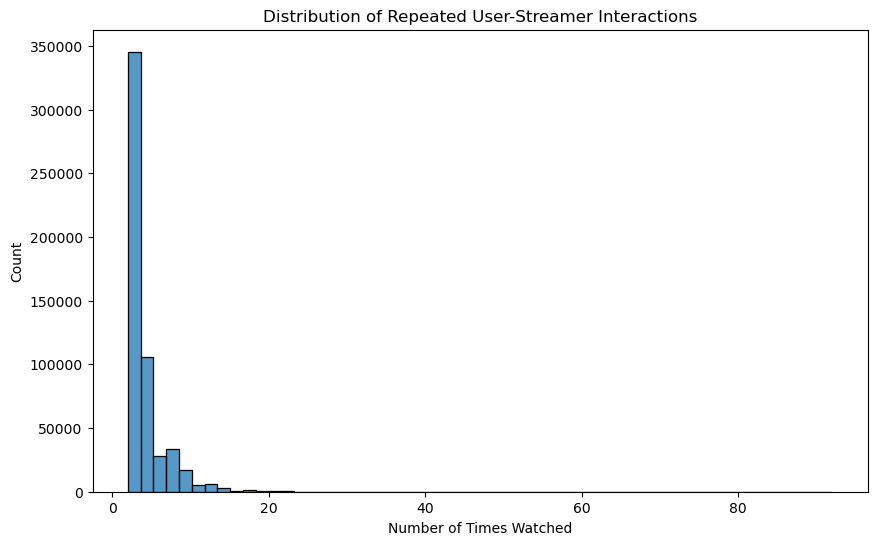

In [15]:
# Distribution of repeated user streamer interactions
user_streamer_pairs_counts = df.groupby(['user_id', 'streamer_name']).size().reset_index(name='watch_count')

# filter for repeated watches
rewatched_pairs = user_streamer_pairs_counts[user_streamer_pairs_counts['watch_count'] > 1]

plt.figure(figsize=(10, 6))
sns.histplot(rewatched_pairs['watch_count'], bins=55)
plt.title('Distribution of Repeated User-Streamer Interactions')
plt.xlabel('Number of Times Watched')

In [16]:
rewatched_pairs['watch_count'].nunique(), rewatched_pairs['watch_count'].value_counts().sort_values(ascending=False)

(55,
 2     234196
 3     111210
 4      64250
 5      41576
 6      27919
 7      19368
 8      13904
 9       9912
 10      7109
 11      5241
 12      3726
 13      2635
 14      1858
 15      1341
 16       952
 17       644
 18       480
 19       341
 20       257
 21       185
 22       148
 23       113
 24        75
 25        68
 26        55
 27        41
 28        39
 29        24
 31        24
 30        21
 33        12
 32        11
 37        10
 36         7
 34         6
 35         6
 39         6
 38         6
 40         5
 41         5
 47         4
 44         3
 42         3
 62         2
 50         2
 52         2
 63         2
 45         2
 78         1
 48         1
 92         1
 82         1
 90         1
 59         1
 61         1
 Name: watch_count, dtype: int64)

Text(0.5, 0, 'Time Spent (minutes)')

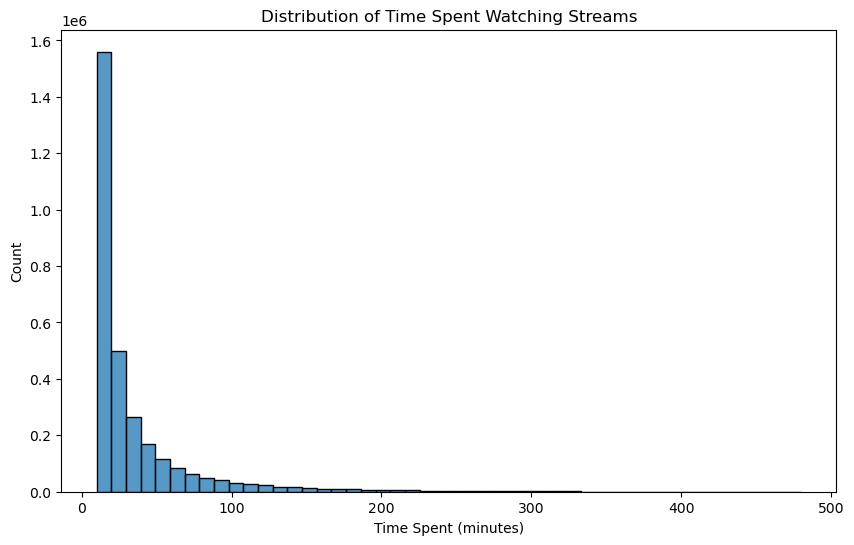

In [17]:
# distribution of time spent
plt.figure(figsize=(10, 6))
sns.histplot(df['time_spent'], bins=48)
plt.title('Distribution of Time Spent Watching Streams')
plt.xlabel('Time Spent (minutes)')

In [18]:
df['time_spent'].nunique(), df['time_spent'].value_counts()

(48,
 10     1559891
 20      498252
 30      263958
 40      168944
 50      115769
 60       85323
 70       64238
 80       49751
 90       40007
 100      32180
 110      26825
 120      22509
 130      18312
 140      15173
 150      12759
 160      10884
 170       9396
 180       8149
 190       6876
 200       5834
 210       4922
 220       4384
 230       3832
 240       3292
 250       2849
 260       2276
 270       1983
 280       1740
 290       1430
 300       1308
 310       1084
 320        996
 330        823
 340        737
 350        688
 360        565
 370        468
 380        426
 390        372
 400        296
 420        276
 410        263
 430        223
 440        207
 450        168
 460        136
 470        134
 480         94
 Name: time_spent, dtype: int64)

In [ ]:
# Top left: Distribution of time spent
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.histplot(df['time_spent'], bins=48)
plt.title('Distribution of Time Spent Watching Streams')
plt.xlabel('Time Spent (minutes)')

# Top right: Top 15 most popular streamers
plt.subplot(2, 2, 2)
sns.barplot(x=top_streamers.index, y=top_streamers.values, palette='deep')
plt.title('Top 15 Streamers')
plt.xlabel('Streamer Name')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')

# Bottom left: Distribution of number of unique streamers watched by user
plt.subplot(2, 2, 3)
sns.histplot(unique_streamers_per_user, bins=156)
plt.title('Distribution of Unique Streamers Watched per User')
plt.xlabel('Number of Unique Streamers')

# Bottom right: Distribution of repeated user streamer interactions
plt.subplot(2, 2, 4)
sns.histplot(rewatched_pairs['watch_count'], bins=55)
plt.title('Distribution of Repeated User-Streamer Interactions')
plt.xlabel('Number of Times Watched')

# Adjust layout
plt.tight_layout()

plt.savefig('eda_figs.png', dpi=500)

In [19]:
# shuffle dataframe
df = df.sample(frac=1, random_state=42)  
df

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
559707,18494,34347867904,forsen,54250,54290,40
81219,2723,34309635472,callofduty,50250,50260,10
301537,10197,34140040400,elraenn,32950,32960,10
986344,32688,33854552896,nubkeks,2650,2710,60
1660926,54764,34196801808,mrbboy45,38680,38690,10
...,...,...,...,...,...,...
1693123,55868,34178329664,wazztv_,36670,36680,10
2356878,77705,34360830384,lol_madlife,55540,55610,70
2229595,73485,34402293776,italiand0g,60020,60060,40
2768969,91071,34033287680,gsl,20950,21000,50


In [20]:
# convert df to list of json
data = df.to_dict(orient='records')

In [21]:
# Build basic data structures for WHOLE dataset:
uniqueStreamers = set() 
watchedSet = set()
streamerPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)
streamerViews = defaultdict(int)
interactionCount = defaultdict(int)
timeDict = {}
userIDs,streamerIDs = {},{}

for d in data:
    user = d['user_id']
    streamer = d['streamer_name']
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not streamer in streamerIDs: streamerIDs[streamer] = len(streamerIDs)
    uniqueStreamers.add(streamer)
    watchedSet.add((user,streamer))
    streamerPerUser[user].add(streamer)
    usersPerStreamer[streamer].add(user)
    streamerViews[streamer] += 1
    interactionCount[(user,streamer)] += 1
    timeDict[(user,streamer)] = d['time_spent']

# Data Preparation

In [22]:
# Split into training, validation, testing
train, temp = train_test_split(data, test_size=0.3, random_state=123)
valid, test = train_test_split(temp, test_size=0.5, random_state=123)

In [23]:
len(data), len(temp), len(valid), len(test)

(3051002, 915301, 457650, 457651)

In [24]:
len(data), len(train) + len(valid) + len(test)

(3051002, 3051002)

In [26]:
## Generate negative samples for validation set
watchedValid = set()
for d in valid:
    watchedValid.add((d['user_id'],d['streamer_name']))

notWatchedValid = set()
for d in valid:
    u = d['user_id']
    s = random.choice(list(uniqueStreamers))
    while (u,s) in watchedSet or (u,s) in notWatchedValid:
        s = random.choice(list(uniqueStreamers))
    notWatchedValid.add((u,s))

In [27]:
## Generate negative samples for testing set
watchedTest = set()
for d in test:
    watchedTest.add((d['user_id'],d['streamer_name']))

notWatchedTest = set()
for d in test:
    u = d['user_id']
    s = random.choice(list(uniqueStreamers))
    while (u,s) in watchedSet or (u,s) in notWatchedTest:
        s = random.choice(list(uniqueStreamers))
    notWatchedTest.add((u,s))

In [28]:
# Build basic data structures for TRAINING dataset:
streamerPerUserTrain = defaultdict(set)
usersPerStreamerTrain = defaultdict(set)
streamerViewsTrain = defaultdict(int)
interactionCountTrain = defaultdict(int)
timeDictTrain = {}

for d in train:
    user = d['user_id']
    streamer = d['streamer_name']
    streamerPerUserTrain[user].add(streamer)
    usersPerStreamerTrain[streamer].add(user)
    streamerViewsTrain[streamer] += 1
    interactionCountTrain[(user,streamer)] += 1
    timeDictTrain[(user,streamer)] = d['time_spent']

# streamerPerUser = defaultdict(set)
# usersPerStreamer = defaultdict(set)
# streamerPopularity = defaultdict(int)
# timeDict = {}

# for index, row in train.iterrows():
#     user = row['user_id']
#     streamer = row['streamer name']
#     time = row['time spent']
#     streamerPerUser[user].add(streamer)
#     usersPerStreamer[streamer].add(user)
#     streamerPopularity[streamer] += 1
#     timeDict[(user,streamer)] = time

## ROC AUC Curve

In [61]:
def plot_roc_curve(true_y, y_prob, title):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = round(roc_auc_score(true_y, y_prob), 4)
    plt.plot(fpr, tpr, label=f'{title} AUC = {auc:.2f}')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [30]:
# y = [[(1, k), (0, y)] for k,y in zip(watchedValid, notWatchedValid)]
y = [1 for _ in watchedValid] +[0 for _ in notWatchedValid]

In [31]:
# cosineLabels

# Models

### Popularity

In [32]:
# Popularity
correct = 0
p1 = 0
popularityLabels = []

for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        pred = 0
        if len(usersPerStreamerTrain[s]) > 11: # 11 seems to be the best lol 
            pred = 1
            p1+= 1
        if pred == label:
            correct += 1
        popularityLabels.append(pred)

correct / (len(watchedValid) + len(notWatchedValid)) , p1

(0.8293801380138014, 247335)

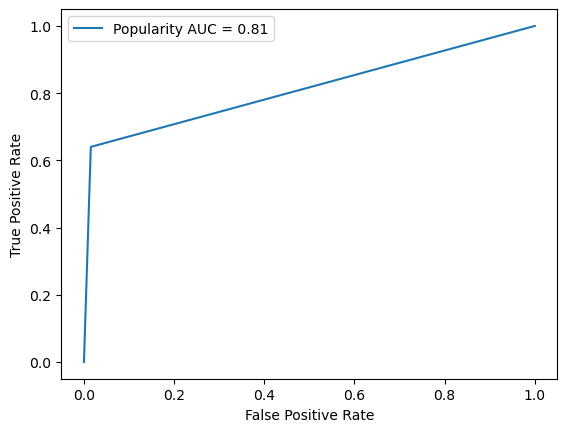

In [62]:
plot_roc_curve(y, popularityLabels, "Popularity")

### Jaccard

In [34]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [35]:
# Jaccard only
correct = 0
p1 = 0
jaccardLabels = []

for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        for s2 in streamerPerUserTrain[u]:
            sim = Jaccard(users,usersPerStreamerTrain[s2])
            if sim == 1:
                maxSim = sim
                break
            if sim > maxSim:
                maxSim = sim
        if maxSim > 0.058:
            pred = 1
            p1 += 1
        if maxSim == float('-inf'):
            jaccardLabels.append(0)
            continue
        if pred == label:
            correct += 1
        jaccardLabels.append(pred)
        
correct / (len(watchedValid) + len(notWatchedValid)) , p1

(0.9109006900690069, 303121)

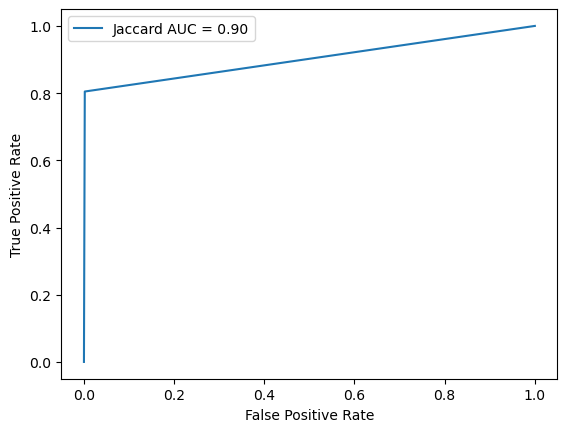

In [63]:
plot_roc_curve(y, jaccardLabels, "Jaccard")

### Jaccard + Popularity

In [37]:
# Jaccard + Popularity
correct = 0
p1 = 0
predLabels = []
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 11:
                pred = 1
                p1 += 1
            predLabels.append(pred)
        # user has been seen before
        else:
            for s2 in streamerPerUserTrain[u]:
                sim = Jaccard(users,usersPerStreamerTrain[s2])
                if sim == 1:
                    maxSim = sim
                    break
                if sim > maxSim:
                    maxSim = sim
            if maxSim > 0.058 or len(usersPerStreamerTrain[s]) > 11:
                pred = 1
                p1 += 1
        if maxSim == float('-inf') and pred == 0:
            predLabels.append(0)
            continue
        if pred == label:
            correct += 1
        predLabels.append(pred)

correct / (len(watchedValid) + len(notWatchedValid)) , p1

(0.930961896189619, 333241)

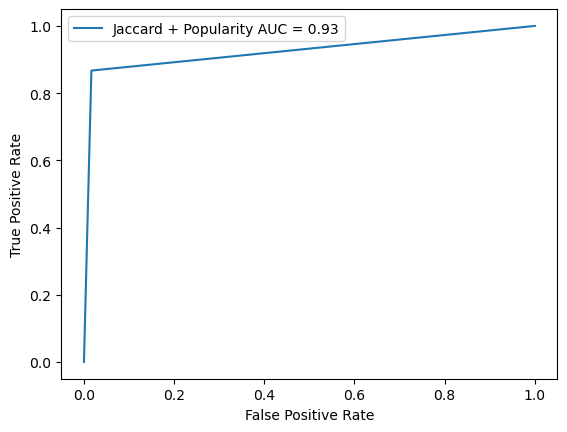

In [64]:
plot_roc_curve(y, predLabels, "Jaccard + Popularity")

### Cosine

In [39]:
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [40]:
# Cosine Only
correct = 0
p1 = 0
cosineLabels = []
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        for s2 in streamerPerUserTrain[u]:
            sim = CosineSet(users,usersPerStreamerTrain[s2])
            if sim > maxSim:
                maxSim = sim
            if maxSim >= 0.9999:
                break
        if maxSim > 0.1:
            pred = 1
            p1 += 1
        if maxSim == float('-inf'):
            cosineLabels.append(pred)
            continue
        if pred == label:
            correct += 1
        cosineLabels.append(pred)

correct / (len(watchedValid) + len(notWatchedValid)) , p1

(0.9246516651665166, 317279)

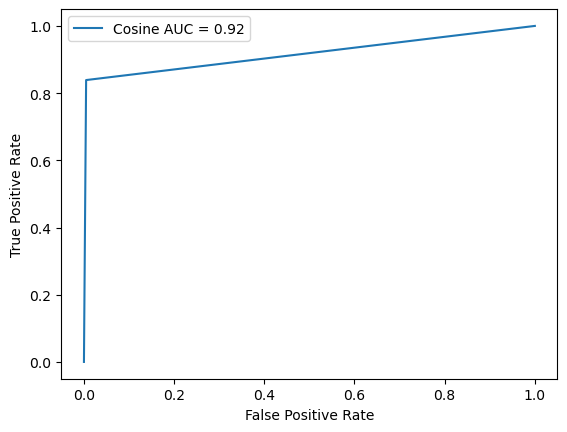

In [65]:
plot_roc_curve(y, cosineLabels, "Cosine")

### All ROC Curves

Text(0, 0.5, 'True Positive Rate')

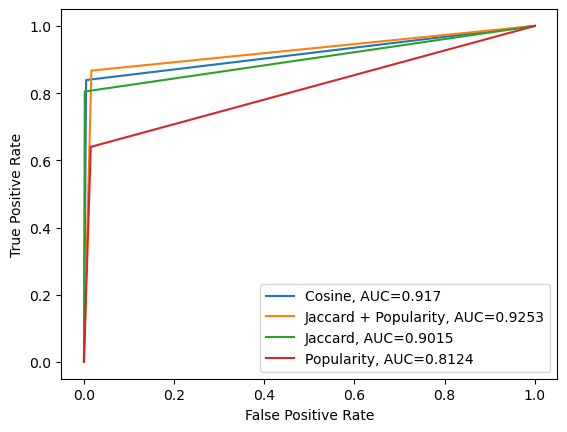

In [69]:
plt.figure(0).clf()

fpr, tpr, _ = roc_curve(y, cosineLabels)
auc = round(roc_auc_score(y, cosineLabels), 4)
plt.plot(fpr,tpr,label="Cosine, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y, predLabels)
auc = round(roc_auc_score(y, predLabels), 4)
plt.plot(fpr,tpr,label="Jaccard + Popularity, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y, jaccardLabels)
auc = round(roc_auc_score(y, jaccardLabels), 4)
plt.plot(fpr,tpr,label="Jaccard, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y, popularityLabels)
auc = round(roc_auc_score(y, popularityLabels), 4)
plt.plot(fpr,tpr,label="Popularity, AUC="+str(auc))

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### BPR (implicit)

In [42]:
# # Build matrix for BPR training
# userIDsTrain,gameIDsTrain = {},{} 
# for u,g in playedTrain:
#     if not u in userIDsTrain: userIDsTrain[u] = len(userIDsTrain)
#     if not g in gameIDsTrain: gameIDsTrain[g] = len(gameIDsTrain)

# # fill up matrix
# XuiTrain = scipy.sparse.lil_matrix((len(userIDsTrain), len(gameIDsTrain)))
# for u,g in playedTrain:
#     XuiTrain[userIDsTrain[u],gameIDsTrain[g]] = 1

# # turn into sprase csr matrix
# XuiTrain_csr = scipy.sparse.csr_matrix(XuiTrain)
# XuiTrain_csr

### BPR (TF)

In [43]:
# add all user-streamer pair for BPR
watchedAll = set()
for d in data:
    watchedAll.add((d['user_id'],d['streamer_name']))

In [44]:
userIDsAll,streamer_nameIDsAll = {},{} 
for u,s in watchedAll:
    if not u in userIDsAll: userIDsAll[u] = len(userIDsAll)
    if not s in streamer_nameIDsAll: streamer_nameIDsAll[s] = len(streamer_nameIDsAll)

In [45]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(streamer_nameIDsAll)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDsAll),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(streamer_nameIDsAll),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [46]:
optimizer = tf.keras.optimizers.legacy.Adam(0.1)

In [47]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(interactions) # positive sample (watchedAll)
            j = random.choice(list(uniqueStreamers)) # negative sample
            while j in streamerPerUserTrain[u]:
                j = random.choice(list(uniqueStreamers))
            sampleU.append(userIDsAll[u])
            sampleI.append(streamer_nameIDsAll[i])
            sampleJ.append(streamer_nameIDsAll[j])
            
        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [48]:
len(uniqueStreamers), len(streamer_nameIDsAll)

(162624, 162624)

In [49]:
modelBPR = BPRbatch(3, 0.00001)
for i in range(100):
    obj = trainingStepBPR(modelBPR, list(watchedAll))
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 10, objective = 0.49582157


KeyboardInterrupt: 

In [ ]:
# BPR model
nUserStreamers = 0
p1 = 0
correct = 0
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]:
    for (u,s) in sample:
        nUserStreamers +=1
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            print('in here')
            if len(usersPerStreamerTrain[s]) > 11:
                pred = 1
                p1 += 1
                print('in here 2')
        else:
            rank = modelBPR.predict(userIDsAll[u], streamer_nameIDsAll[s]).numpy()
            if rank > 0.3:
                pred = 1
                p1 +=1 
        if pred == label:
            correct += 1

bpr_acc = correct / (len(watchedValid) + len(notWatchedValid))
bpr_acc

In [ ]:
p1, nUserStreamers - p1, nUserStreamers # 309617, 523633 for 0.5

In [ ]:
# # Tune BPR Threshold:
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# bpr_accs = []

# for threshold in thresholds:
#     nUserStreamers = 0
#     p1 = 0  
#     correct = 0
#     for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]:
#         for (u,s) in sample:
#             nUserStreamers +=1
#             pred = 0
#             rank = modelBPR.predict(userIDsAll[u], streamer_nameIDsAll[s]).numpy()
#             if rank > threshold:
#                 pred = 1
#                 p1 +=1 
#             if pred == label:
#                 correct += 1
#     bpr_accs.append( (correct / (len(watchedValid)+len(notWatchedValid)), threshold, p1, nUserStreamers-p1 ) )

In [ ]:
# bpr_accs

In [ ]:
# def plot_roc_curve(true_y, y_prob):
#     fpr, tpr, thresholds = roc_curve(true_y, y_prob)
#     plt.plot(fpr, tpr)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')

In [ ]:
# # y = [[(1, k), (0, y)] for k,y in zip(watchedValid, notWatchedValid)]
# y = [1 for _ in watchedValid] +[0 for _ in notWatchedValid]

In [ ]:
# cosineLabels

In [ ]:
# plot_roc_curve(y, cosineLabels)